In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_openml
import math

np.random.seed(420)

# load ds

In [2]:

def load_ds(name, num_test, shape=None):
    """
    fetch dataset from openML.org and split to train/test
    @param name - ID on openML (eg. 'mnist_784')
    @param num_test - num. samples to take as test
    @param shape - new reshape of a single data point (ie data['data'][0]) as a list. Eg. [28,28] for MNIST
    """
    data = fetch_openml(name, version=1, data_home='./data', cache=True)
    sz=data['target'].shape[0]

    X = data['data']
    if shape is not None:
        new_shape = shape.insert(0, sz)
        X = np.reshape(X, new_shape)

    y = data['target'].astype(np.int32)
    # split to train/test data
    train_labels = y[:sz-num_test]
    train_images = X[:sz-num_test]
    test_labels  = y[sz-num_test:]
    test_images  = X[sz-num_test:]

    return train_labels, train_images, test_labels, test_images


def shuffle_data(x, y):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x, y = np.array(x), np.array(y)
    return x[indices], y[indices]


def plot_flatten_image(flatten_image, image_height=28):
    plt.imshow(flatten_image.reshape((image_height, -1)))


def to_binary_flatten_images(images):
    n_samples = images.shape[0]
    # flatten every image to vector
    images = images.reshape((n_samples, -1))
    # binary encoding: each image pixel is encoded either 0 or 1 depending on that image mean value
    images = (images >= images.mean(axis=1, keepdims=True)).astype(np.int8)
    return images


backprop_errors = []


numpy DS loaded


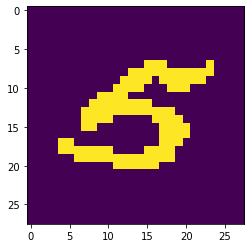

In [4]:
train_labels, train_images, test_labels, test_images = load_ds('mnist_784', 10000, shape=[28,28])

train_images, train_labels = shuffle_data(train_images, train_labels)
test_images, test_labels = shuffle_data(test_images, test_labels)

n_train_samples = train_images.shape[0]
n_test_samples = test_images.shape[0]
image_shape = train_images[0].shape
image_side = image_shape[0]
image_size = image_side ** 2
train_images = to_binary_flatten_images(train_images)
test_images = to_binary_flatten_images(test_images)
plot_flatten_image(train_images[0])
print('numpy DS loaded')

#  NN

array([[ 0.00195984, -0.06299073],
       [ 0.07428486,  0.0225851 ]])

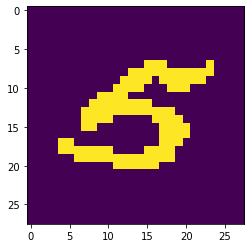

In [243]:
from math import sqrt

def act_function_derivative_np(states: np.ndarray):
    return np.ones(states.size)-states*states

def horizontal(vector: np.ndarray) -> np.ndarray:
    return vector.reshape(1, vector.size)

def vertical(vector: np.ndarray) -> np.ndarray:
    return vector.reshape(vector.size, 1)

def plot_flatten_image(flatten_image, image_height=28):
    plt.imshow(flatten_image.reshape((image_height, -1)))

def clip(vector: np.ndarray, max_len: float) -> np.ndarray:
    len_sq = (vector**2).sum()
    if len_sq > max_len**2:
        return (max_len/sqrt(len_sq))*vector
    else:
        return vector
def one_hot(label, num_classes = 10):
    result = np.zeros(num_classes)
    result[label] = 1
    return result

def error_matrix(weights, shape: tuple):
    return np.random.normal(0, 0.75, shape)
class MLP:
    def __init__(self, layers_sizes: list, error_matrices_func=error_matrix):
        layers_num = len(layers_sizes)

        self.layers_num = layers_num

        self.layers = [0]*layers_num

        self.weights = [0] * (layers_num - 1)
        self.bias = [0] * (layers_num-1)

        self.error_matrices = []
        for i in range(layers_num):
            self.layers[i] = np.ndarray((layers_sizes[i], 1))
            if i != layers_num - 1:
                self.weights[i] = np.random.normal(0, 0.1, (layers_sizes[i + 1], layers_sizes[i]))
                self.bias[i] = np.random.normal(0, 0.1, (layers_sizes[i+1]))

                self.error_matrices.append(error_matrices_func(self.weights[i], (layers_sizes[i], 10)))
                # self.error_matrices.append(np.random.normal(0, 0.75, (layers_sizes[i], layers_sizes[i+1])))
                # self.error_matrices.append(np.sign(self.weights[i].transpose())/2)
                # self.error_matrices.append(np.random.uniform(-1, 1, (layers_sizes[i], layers_sizes[i+1])))
                # self.error_matrices.append(7.5*self.weights[i].transpose().copy())

    def common_forward(self, x: np.ndarray):
        x = x.flatten()
        self.layers[0] = x
        for i in range(self.layers_num - 1):
            self.layers[i+1] = np.tanh(self.weights[i] @ self.layers[i] + self.bias[i])
        return self.layers[self.layers_num-1]

    def forward(self, optimizer: str, inputs):
        return self.common_forward(inputs)


    def backprop(self, targets: np.ndarray, spd: float = 0.003):

        layer = self.layers_num - 1

        delta = self.layers[layer] - targets

        while layer >= 1:
            input_grad = delta * act_function_derivative_np(self.layers[layer])
            self.weights[layer-1] -= spd*vertical(input_grad) @ horizontal(self.layers[layer-1])
            self.bias[layer-1] -= spd*input_grad
            if layer != 1:
                delta = (self.weights[layer-1].transpose() @ vertical(input_grad)).flatten()
            layer -= 1
    def lrr_step(self, targets: np.ndarray, spd: float = 0.003):
        layers_targets = [0]*self.layers_num

        layer = self.layers_num - 1
        layers_targets[layer] = targets
        outputs = self.layers[layer]
        E = np.identity(len(outputs))
        while layer >= 1:
            delta = self.layers[layer]-layers_targets[layer]
            input_grad = delta * act_function_derivative_np(self.layers[layer])
            self.weights[layer-1] -= spd*vertical(input_grad) @ horizontal(self.layers[layer-1])
            self.bias[layer-1] -= spd*input_grad
            if layer != 1:
                E = self.error_matrices[layer-1]
                layers_targets[layer-1] = E @ targets
            layer -= 1

    def FA_step(self, targets: np.ndarray, spd: float = 0.003):
        layer = self.layers_num - 1
        delta = self.layers[layer] - targets

        while layer >= 1:
            input_grad = delta * act_function_derivative_np(self.layers[layer])
            self.weights[layer-1] -= spd*vertical(input_grad) @ horizontal(self.layers[layer-1])
            self.bias[layer-1] -= spd*input_grad
            if layer != 1:
                delta = self.error_matrices[layer-1] @ delta
            layer -= 1

    def optim_step(self, optimizer, targets: np.ndarray, **kwargs):
        if optimizer == 'bp':
            self.backprop(targets, **kwargs)
        elif optimizer == 'FA':
            self.FA_step(targets, **kwargs)
        elif optimizer == 'lrr':
            self.lrr_step(targets, **kwargs)
        else:
            raise Exception('wrong optimizer')


inputs_v = train_images[0]
labels_v = train_labels[0]
mlp_test = MLP([784, 16, 16, 10], error_matrices_func=error_matrix)
for i in range(1000):
    mlp_test.forward('FA', inputs_v)
    mlp_test.lrr_step(one_hot(labels_v))
plot_flatten_image(inputs_v.flatten())
clip(np.random.normal(0, 0.1, (2,2)), 0.1)

In [209]:


def np_learn(nt: MLP, train_im, train_lb, epochs=3, optimizer = 'bp', errors_container = backprop_errors, **kwargs):
    step = 500
    upper_bound = train_im.shape[0]
    bar = tqdm(range(math.ceil(upper_bound*epochs/step)))
    spd = 0.01
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, inputs in enumerate(train_im, 0):

            labels = one_hot(train_lb[i])
            outputs = nt.forward(optimizer, inputs)
            nt.optim_step(optimizer, labels, spd=spd, **kwargs)

            loss = ((outputs - labels) ** 2).mean(axis=0)
            running_loss += loss

            if i % step == step-1:
                spd *= 0.995
                bar.update()
                mean_loss = running_loss / step
                errors_container.append(mean_loss)
                running_loss = 0.0

# Experiments

In [9]:
layers = [784, 16, 16, 10]
train_size = 100000
epochs = 3

In [15]:
backprop_errors = []
mlp = MLP(layers)
np_learn(
    mlp,
    train_images[:train_size],
    train_labels[:train_size],
    epochs=epochs,
    optimizer='bp',
    errors_container=backprop_errors
)

  0%|          | 0/360 [00:00<?, ?it/s]

In [196]:
FA_errors = []
mlp = MLP(layers)
np_learn(
    mlp,
    train_images[:train_size],
    train_labels[:train_size],
    epochs=epochs,
    optimizer='FA',
    errors_container=FA_errors
)

  0%|          | 0/360 [00:00<?, ?it/s]

In [87]:
def old_weights(weights, shape):
    return 7.5*weights.transpose().copy()

old_weights_errors = []
mlp = MLP(
    layers,
    error_matrices_func=old_weights
)
np_learn(
    mlp,
    train_images[:train_size],
    train_labels[:train_size],
    epochs=epochs,
    optimizer='FA',
    errors_container=old_weights_errors
)

  0%|          | 0/360 [00:00<?, ?it/s]

## Calculations

$d\_delta=deep\_delta = E delta$

------------------------------
$d\_z - d\_t = E delta$

-----------------------------
$d\_t = d\_z - E delta$

-----------------------------
$d\_t = d\_z - E (z-t)$

------------------------------
$d\_t = d\_z - Ez+Et$

------------------------------
### repsh

$d\_t = d\_z + Et$

In [241]:
lrr_errors = []
mlp = MLP(layers)
np_learn(
    mlp,
    train_images[:train_size],
    train_labels[:train_size],
    epochs=epochs,
    optimizer='lrr',
    errors_container=lrr_errors
)

  0%|          | 0/360 [00:00<?, ?it/s]

Text(0.5, 1.0, '3 layers')

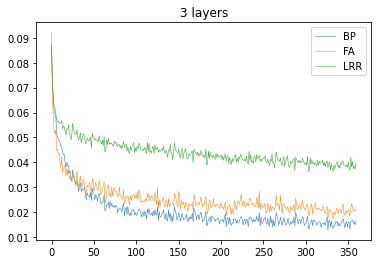

In [242]:
plt.plot(range(len(backprop_errors)),    backprop_errors,       label='BP',         linewidth=0.5)
plt.plot(range(len(FA_errors)),          FA_errors,             label='FA',         linewidth=0.5)
# plt.plot(range(len(old_weights_errors)), old_weights_errors,    label='old_weights',linewidth=0.5)
plt.plot(range(len(lrr_errors)),         lrr_errors,            label='LRR',         linewidth=0.5)
plt.legend()
plt.title(f'{len(layers)-1} layers')